This notebook is to demonstrate the working of pretrained Detectree2 model with DataLoaders from the chipping logic developed for tree-detection-framework
--

In [1]:
import os

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation.coco_evaluation import instances_to_coco_json

from tree_detection_framework.preprocessing.preprocessing import create_dataloader, visualize_dataloader
from torchgeo.datasets import unbind_samples
import matplotlib.pyplot as plt

Setup config expected by Detectree2
--
setup_cfg() is a function from `detectree2` library

In [2]:
def setup_cfg(
    base_model: str = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
    trains=("trees_train",),
    tests=("trees_val",),
    update_model=None,
    workers=2,
    ims_per_batch=2,
    gamma=0.1,
    backbone_freeze=3,
    warm_iter=120,
    momentum=0.9,
    batch_size_per_im=1024,
    base_lr=0.0003389,
    weight_decay=0.001,
    max_iter=1000,
    num_classes=1,
    eval_period=100,
    out_dir="./train_outputs",
    resize=True,
):
    """Set up config object # noqa: D417.

    Args:
        base_model: base pre-trained model from detectron2 model_zoo
        trains: names of registered data to use for training
        tests: names of registered data to use for evaluating models
        update_model: updated pre-trained model from detectree2 model_garden
        workers: number of workers for dataloader
        ims_per_batch: number of images per batch
        gamma: gamma for learning rate scheduler
        backbone_freeze: backbone layer to freeze
        warm_iter: number of iterations for warmup
        momentum: momentum for optimizer
        batch_size_per_im: batch size per image
        base_lr: base learning rate
        weight_decay: weight decay for optimizer
        max_iter: maximum number of iterations
        num_classes: number of classes
        eval_period: number of iterations between evaluations
        out_dir: directory to save outputs
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(base_model))
    cfg.DATASETS.TRAIN = trains
    cfg.DATASETS.TEST = tests
    cfg.DATALOADER.NUM_WORKERS = workers
    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.GAMMA = gamma
    cfg.MODEL.BACKBONE.FREEZE_AT = backbone_freeze
    cfg.SOLVER.WARMUP_ITERS = warm_iter
    cfg.SOLVER.MOMENTUM = momentum
    cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = batch_size_per_im
    cfg.SOLVER.WEIGHT_DECAY = weight_decay
    cfg.SOLVER.BASE_LR = base_lr
    cfg.OUTPUT_DIR = out_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    if update_model is not None:
        cfg.MODEL.WEIGHTS = update_model
    else:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model)

    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.TEST.EVAL_PERIOD = eval_period
    cfg.RESIZE = resize
    cfg.INPUT.MIN_SIZE_TRAIN = 1000
    return cfg

In [3]:
trained_model = "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"  # Load pretrained weights from local
cfg = setup_cfg(update_model=trained_model)
predictor = DefaultPredictor(cfg)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retu

In [5]:
raster_dir = "/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho"  # Path to raster image

In [6]:
dataloader = create_dataloader(
    raster_folder_path=raster_dir, chip_size=1000, chip_overlap_percentage=20, use_units_meters=False
)

`dataloader` has the input raster image chipped into tiles

In [7]:
len(dataloader)  # number of tiles

144

In [8]:
dataloader.sampler.res  # verify resolution

0.033193537568046896

Visulaize the tiled data
--

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


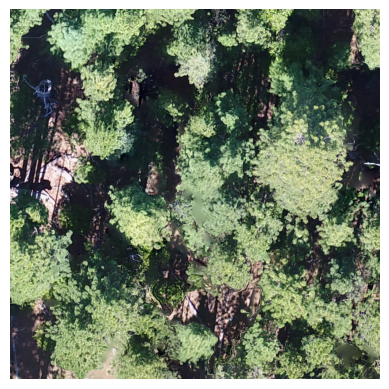

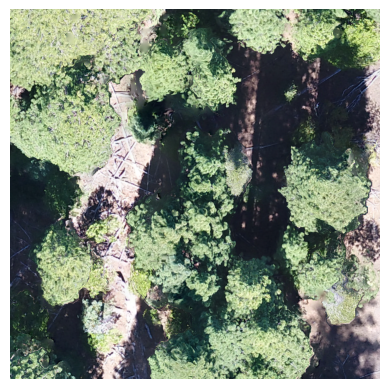

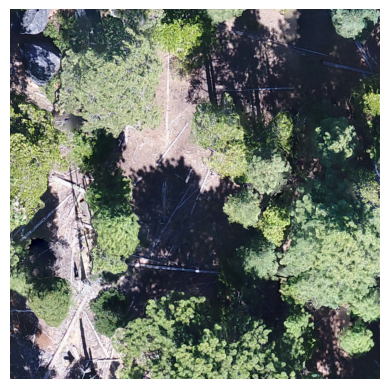

In [9]:
visualize_dataloader(dataloader, 3)

Predict
--

In the future we will call the predict method defined by the `LightningDetector` class. But the below function does the predictions for now in limited steps.

In [10]:
def predict_tiles(dataloader):
    outputs = []
    for i, tile in enumerate(dataloader):
        sample = unbind_samples(tile)[0]
        
        image = sample['image'].permute(1, 2, 0).byte().numpy()
        outputs.append(predictor(image[:,:,:3]))

    return outputs

save predictions in `outputs`

In [ ]:
outputs = predict_tiles(dataloader)

In [12]:
len(outputs)

144

In [13]:
instance = outputs[0] # first tile's predictions

Every tile has its own set of `pred_boxes`, `scores`, `pred_classes`, `pred_masks`

In [14]:
fields = instance['instances'].get_fields()

In [15]:
fields.keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

`pred_masks` is a list which has individual binary masks for every tile

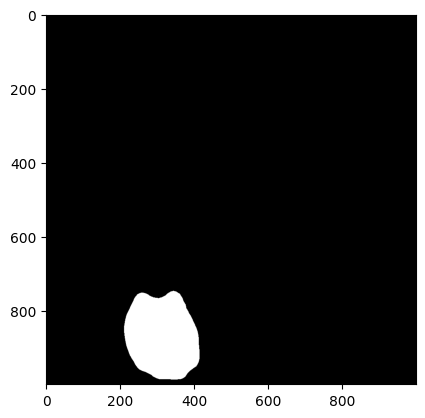

In [33]:
plt.imshow(fields['pred_masks'][0].cpu().numpy(), cmap='gray') # displaying the first mask

Below are some functions to help visualize the predicted crowns and bounding-boxes for individual tiles
--

In [20]:
from shapely.geometry import Polygon

In [30]:
def plot_predictions(image, fields, score_threshold=0.5):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(image)

    # Extract bounding boxes, masks, and scores
    pred_boxes = fields['pred_boxes'].tensor.cpu().numpy()
    pred_masks = fields['pred_masks'].cpu().numpy()
    pred_scores = fields['scores'].cpu().numpy()

    # Filter by score threshold
    valid_indices = pred_scores > score_threshold
    pred_boxes = pred_boxes[valid_indices]
    pred_masks = pred_masks[valid_indices]

    # Plot bounding boxes
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    # Plot masks (overlayed as contours)
    for i, mask in enumerate(pred_masks):
        plt.contour(mask, levels=[0.5], colors='blue')

    plt.title(f"Detected Trees with confidence scores > {score_threshold}")
    plt.axis('off')
    plt.show()


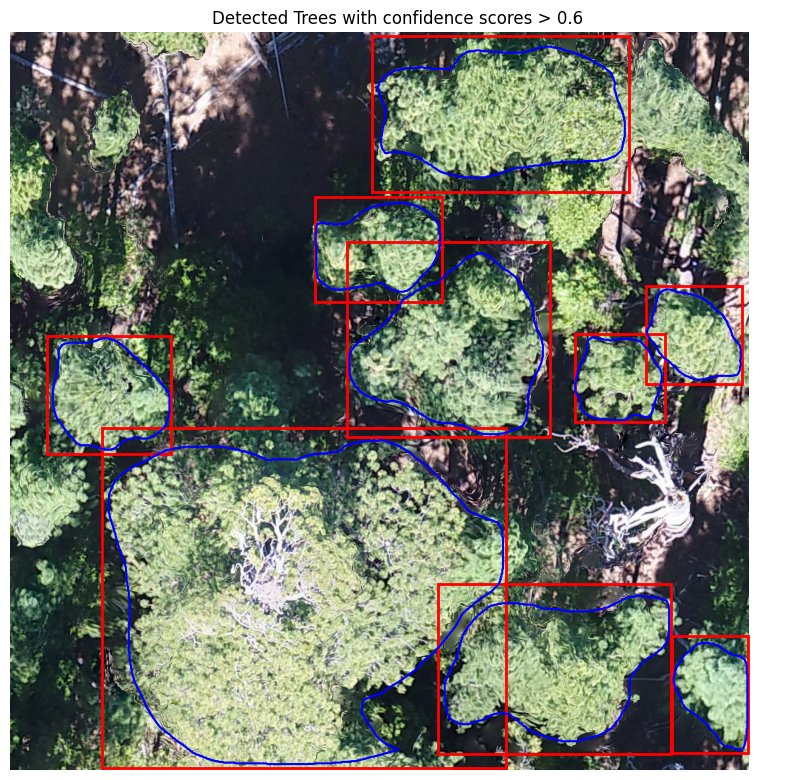

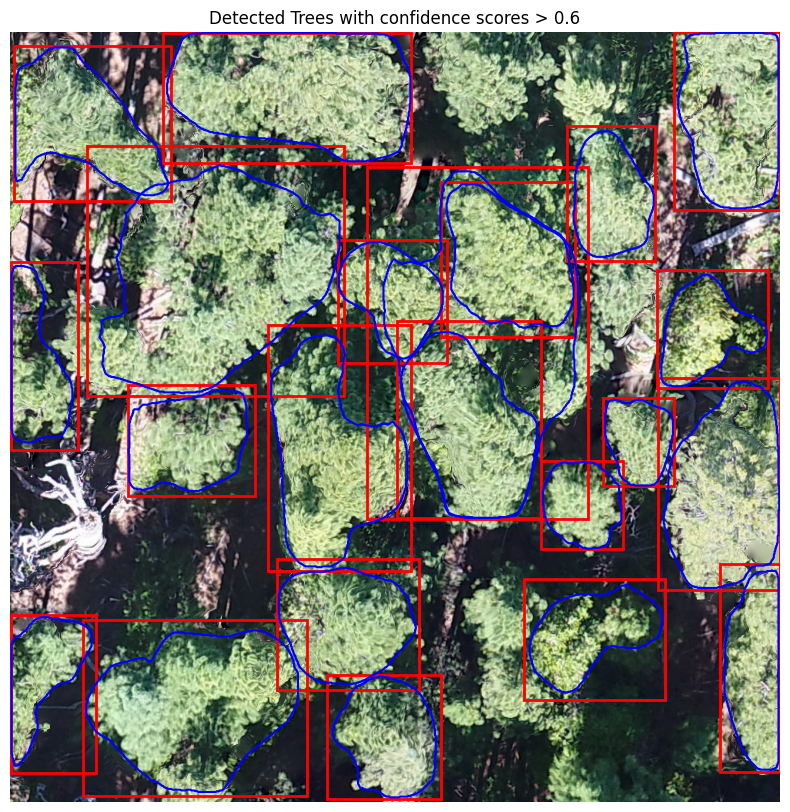

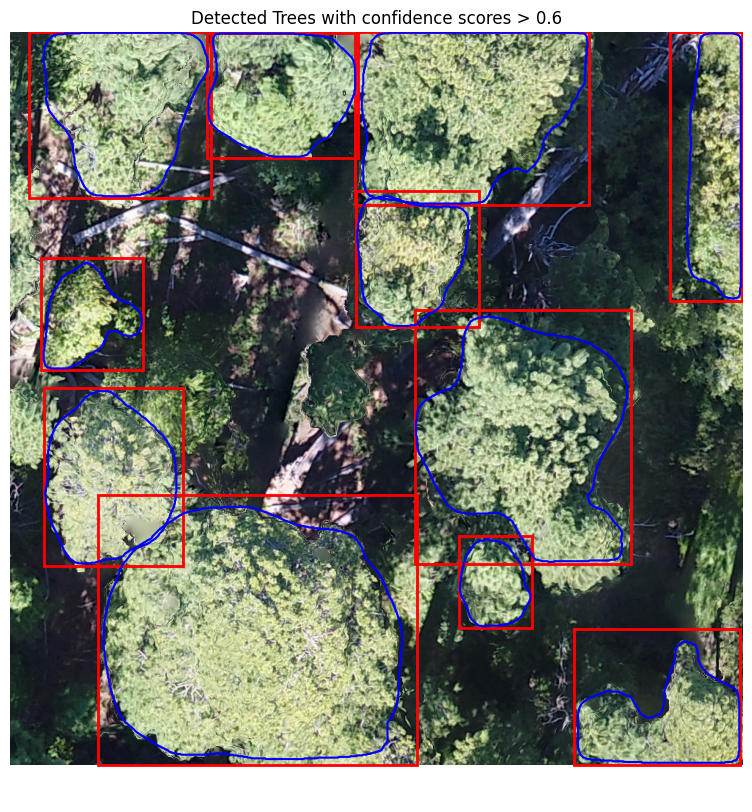

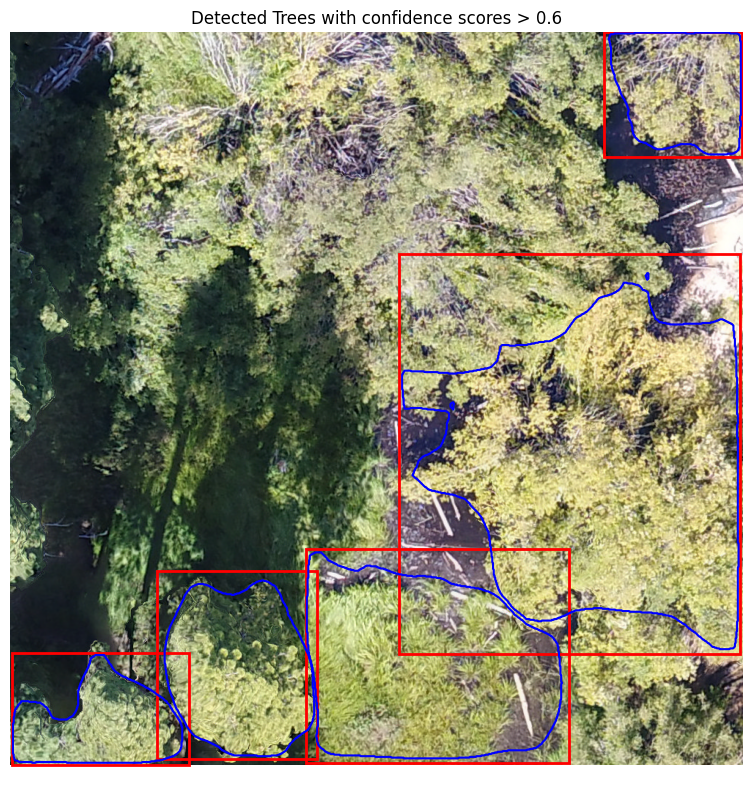

In [31]:
for i, tile in enumerate(dataloader):
    if 30 < i < 35:
        sample = unbind_samples(tile)[0]
        instance = outputs[i]
        fields = instance['instances'].get_fields()
        image = sample['image'].permute(1, 2, 0).byte().cpu().numpy()

        plot_predictions(image, fields, score_threshold=0.6)


Since the crowns are returned as binary masks, we need to convert them to `shapely` object polygons

In [23]:
def convert_masks_to_polygons(fields, score_threshold=0.5):
    pred_masks = fields['pred_masks'].cpu().numpy()
    pred_scores = fields['scores'].cpu().numpy()

    # Filter by score threshold
    valid_indices = pred_scores > score_threshold
    pred_masks = pred_masks[valid_indices]

    polygons = []
    for mask in pred_masks:
        # Convert mask to polygons by extracting contours
        contours = plt.contour(mask, levels=[0.5], colors='blue')
        for contour_path in contours.collections[0].get_paths():
            vertices = contour_path.vertices
            shapely_poly = Polygon(vertices)
            polygons.append(shapely_poly)

    return polygons

/tmp/ipykernel_3830/451143350.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for contour_path in contours.collections[0].get_paths():


Tile 0: 19 polygons
Tile 1: 16 polygons
Tile 2: 11 polygons
Tile 3: 10 polygons
Tile 4: 18 polygons


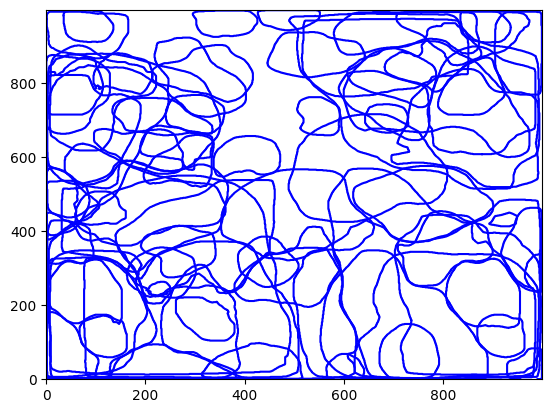

In [24]:
for i, tile in enumerate(dataloader):
    if i < 5:
        instance = outputs[i]
        fields = instance['instances'].get_fields()

        # Convert masks to polygons
        polygons = convert_masks_to_polygons(fields, score_threshold=0.5)
        print(f"Tile {i}: {len(polygons)} polygons")

ignore the above plot

In [28]:
type(polygons[0])

shapely.geometry.polygon.Polygon

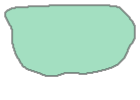

In [26]:
polygons[4]

Originally, `detectree2` requires the tiles data to be saved to disk. The tiles are then read from disk to make predictions which requires a lot of additional steps. 

This is the original prediction fuction from `detectree2`:
--

In [ ]:
def predict_on_data(
    directory: str = "./",
    out_folder: str = "predictions",
    predictor=DefaultPredictor,
    eval=False,
    save: bool = True,
    num_predictions=0,
):
    """Make predictions on tiled data.

    Predicts crowns for all png images present in a directory and outputs masks as jsons.
    """

    # pred_dir = os.path.join(directory, out_folder)
    pred_dir = (
        "/ofo-share/scratch-amritha/tree-detection-framework-scratch/dtree2_predictions"
    )

    Path(pred_dir).mkdir(parents=True, exist_ok=True)

    if eval:
        dataset_dicts = get_tree_dicts(directory)
    else:
        dataset_dicts = get_filenames(directory)

    total_files = len(dataset_dicts)

    # Works out if all items in folder should be predicted on
    if num_predictions == 0:
        num_to_pred = len(dataset_dicts)
    else:
        num_to_pred = num_predictions

    print(f"Predicting {num_to_pred} files")

    for i, d in enumerate(dataset_dicts[:num_to_pred], start=1):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)

        # Creating the file name of the output file
        file_name_path = d["file_name"]
        # Strips off all slashes so just final file name left
        file_name = os.path.basename(os.path.normpath(file_name_path))
        file_name = file_name.replace("png", "json")
        output_file = os.path.join(pred_dir, f"Prediction_{file_name}")
        # print(output_file)

        if save:
            # Converting the predictions to json files and saving them in the
            # specfied output file.
            evaluations = instances_to_coco_json(
                outputs["instances"].to("cpu"), d["file_name"]
            )
            with open(output_file, "w") as dest:
                json.dump(evaluations, dest)

        if i % 50 == 0:
            print(f"Predicted {i} files of {total_files}")